In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt

#start date
start = dt.datetime(2015,1,1)
#last data point to download      
end = dt.datetime(2020,1,1) 

#symbol
symbol = 'TSLA' 

##source of the data
source = 'yahoo'

#read the data frome the web
df = web.DataReader(symbol, source, start)[["Close"]]
#reset the index to make date callable
df.reset_index(inplace=True)

In [3]:
#check the shape
df.shape

(1477, 2)

In [4]:
len(df)

1477

In [5]:
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)

In [6]:
training_set = df[df["Date"] < "01/01/2019"][["Close"]]
test_set = df[(df["Date"] >= "01/01/2019") & (df["Date"] < "01/01/2020")][["Close"]]

In [7]:
#feature scaling
sc = MinMaxScaler(feature_range =(0,1))
training_set_scaled = sc.fit_transform(training_set)

#creating a datastructure with 60 time-steps
X_train = []
y_train = []
for i in range(60, 1006):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
#get the sequential model
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#adding a fifth LSTM layer 
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
946/946 [==============================] - 3s 3ms/step - loss: 0.0733
Epoch 2/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0173
Epoch 3/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 4/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0146
Epoch 5/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 6/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 7/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0124
Epoch 8/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0125
Epoch 9/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0132A: 0s - loss: 0.013
Epoch 10/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0113
Epoch 11/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0100
Epoch 12/100
946/946 [==============================] - 2s 2ms/step - loss: 0

946/946 [==============================] - 2s 2ms/step - loss: 0.0028
Epoch 100/100
946/946 [==============================] - 2s 2ms/step - loss: 0.0026


In [9]:
# Getting the data prior to 2019
dataset_train = df[df["Date"] < "01/01/2019"][["Close"]]
#getting the validation dataset for 2019
dataset_test = df[(df["Date"] >= "01/01/2019") & (df["Date"] < "01/01/2020")][["Close"]]
#adding the dataframes together
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
#getting the length of the input values to use
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#reshaping the inputs
inputs = inputs.reshape(-1,1)
#transforming the inputs using the min-max transformation to standardise
inputs = sc.transform(inputs)
#getting out the test dataset
X_test = []
#getting the previous 60 days worth of information
for i in range(60, 312):
    X_test.append(inputs[i-50:i, 0])
#turning this into an array
X_test = np.array(X_test)
#reshaping the array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [10]:
#use the model to predict the stock price
predicted_stock_price = model.predict(X_test)
#inversley transform the data
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

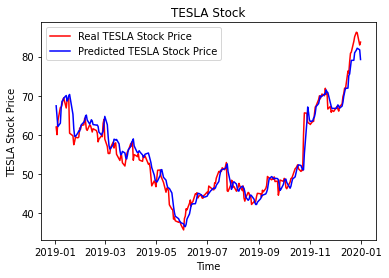

In [11]:
# Visualising the results
plt.plot(df[(df["Date"] >= "01/01/2019") & (df["Date"] < "01/01/2020")][["Date"]],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df[(df["Date"] >= "01/01/2019") & (df["Date"] < "01/01/2020")][["Date"]],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.title('TESLA Stock')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [12]:
#extract the values
test_values = [float(x) for x in dataset_test.values]
predicted = [float(x) for x in predicted_stock_price]

In [13]:
#get the pearson correlation coefficient between the predicted and actual stock prices
from scipy.stats import pearsonr
corr, p = pearsonr(test_values, predicted)
print(corr)
print(p)

0.9763946744946268
2.1051576645224232e-168
